In [ ]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, BatchNormalization, Reshape, Conv1D, Conv2D, \
MaxPooling2D, AveragePooling1D, Concatenate, Dropout, Input, Flatten
import tensorflow as tf
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import os
os.chdir('/content/Implementation-Code-A-novel-validation-framework-to-enhance-deep-learning-models-main')
from utils.Evaluation import RegressionEvaluation, smape
from utils.fileHandling import getData
from utils.fileHandling import splitData
from utils.BLAS import create_dataset
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import gc
#path_parent = os.path.dirname(os.getcwd())
#os.chdir(path_parent)
#os.chdir(path_parent)
#os.chdir('Data')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def process_data(name, strat = 'Differenced', lg = 7):
    SeriesName     = name
    Strategy       = strat # Differenced, Returns
    Lag = lg
    Dates      = ['2020-03-01',     '2020-05-31'] # These are the dates of the validation set
    Series, Transformed_Series = getData('Data/' + SeriesName + '.csv', Strategy) # Transforms the series based on the difference between values
    # The transformed series starts from January 2nd 2017, and the orther series starts at January 1st
    # Transforms the Series using np.log
    
    # These split the data according to the datetime. The training set  is any data before the start date of the validation data
    # The validation data is anything between the dates above, and the test data is any date after the training data.
    Training,      Validation,      Testing      = splitData(Series,             Dates)
    Training_diff, Validation_diff, Testing_diff = splitData(Transformed_Series, Dates)

    # Takes the last lag (eg. 7) days of the training data and concatenates it with the validation set to create the validation set.
    # -Traditional Series
    Validation      = pd.concat([Training.iloc[-Lag:],   Validation])
    Testing         = pd.concat([Validation.iloc[-Lag:], Testing])
    # Takes the last lag (eg. 7) days of the validation data and concatenates it with the testing set to create the testing set.
    # -Differenced Series
    Validation_diff = pd.concat([Training_diff.iloc[-Lag:],   Validation_diff])
    Testing_diff    = pd.concat([Validation_diff.iloc[-Lag:], Testing_diff])
    
    # Uses a sliding window of size lage (eg. 7) to create the X data. Then takes the lag+1 (eg. 8) data point to create the Y value
    if (strat == 'Differenced'):
      trainX, trainY = create_dataset(Training_diff,   Lag, SeriesName)
      validX, validY = create_dataset(Validation_diff, Lag, SeriesName)
      testX,  testY  = create_dataset(Testing_diff,    Lag, SeriesName)
      #validY = Validation[SeriesName][Lag-1:-1 ].to_numpy() + validY # Not needed
      #trainY = Validation[SeriesName][Lag-1:-1 ].to_numpy() + validY # Not needed

    else:
      trainX, trainY = create_dataset(Training,   Lag, SeriesName)
      validX, validY = create_dataset(Validation, Lag, SeriesName)
      testX,  testY  = create_dataset(Testing,    Lag, SeriesName)

    # Changed the validX and the testX to transform, because we won't have enought info to fit in real life.
    scaler = StandardScaler()
    trainX = np.expand_dims( scaler.fit_transform(trainX[:,:,0]), axis=-1)
    validX = np.expand_dims( scaler.transform(validX[:,:,0]), axis=-1)
    testX  = np.expand_dims( scaler.transform(testX[:,:,0]),  axis=-1)
    
    test_data = Testing
    
    return trainX,trainY, validX,validY, testX,testY, test_data

In [ ]:
np.random.seed(24)
tf.random.set_seed(24)

SeriesName     = 'BTC'
Strategy       = 'Differenced' # Differenced, Returns
Lag = 7

trainX_eth,trainY_eth, validX_eth,validY_eth, testX_eth,testY_eth, Testing_eth = process_data('ETH', Strategy, Lag)
trainX_btc,trainY_btc, validX_btc,validY_btc, testX_btc,testY_btc, Testing_btc = process_data('BTC', Strategy, Lag)
trainX_xrp,trainY_xrp, validX_xrp,validY_xrp, testX_xrp,testY_xrp, Testing_xrp = process_data('XRP', Strategy, Lag)

if (SeriesName == 'ETH'):
    trainX,trainY, validX,validY, testX,testY, Testing = trainX_eth,trainY_eth, validX_eth,validY_eth, testX_eth,testY_eth, Testing_eth

elif (SeriesName == 'BTC'):
    trainX,trainY, validX,validY, testX,testY, Testing = trainX_btc,trainY_btc, validX_btc,validY_btc, testX_btc,testY_btc, Testing_btc

else:
    trainX,trainY, validX,validY, testX,testY, Testing = trainX_xrp,trainY_xrp, validX_xrp,validY_xrp, testX_xrp,testY_xrp, Testing_xrp

[INFO] Strategy: Differenced was selected
[INFO] Strategy: Differenced was selected
[INFO] Strategy: Differenced was selected


In [ ]:
def basecomp(printsummary):
    
    def cryptcomp(modinput, layer_act = 'relu'):

        conv = Conv1D(16,2, activation=layer_act)(modinput) #should we add padding?
        pool = AveragePooling1D(2)(conv)
        #flat = Flatten()(pool)
        #re2 = Reshape((flat.shape[1],1))(flat)
        lstm = LSTM(50)(pool)
        return lstm
    
    inshape1 = trainX.shape[1]
    inshape2 = trainX.shape[2]
    input1 = Input(shape=(inshape1, inshape2))
    input2 = Input(shape=(inshape1, inshape2))
    input3 = Input(shape=(inshape1, inshape2))
    out1 = cryptcomp(input1)
    out2 = cryptcomp(input2)
    out3 = cryptcomp(input3)

    concat = Concatenate()([out1,out2,out3])
    dense1 = Dense(256, activation = 'relu')(concat)
    batchnorm1 = BatchNormalization()(dense1)
    drop1 = Dropout(3/10)(batchnorm1)
    dense2 = Dense(64, activation = 'relu')(drop1)
    batchnorm2 = BatchNormalization()(dense2)
    drop2 = Dropout(2/10)(batchnorm2)
    final = Dense(1)(drop2)

    model = Model(inputs = [input1, input2, input3], outputs = final)
    
    if printsummary:
        model.summary()
        
    return model

In [ ]:
def novelcomp(printsummary = False, k1 = 1, k2 = 2, k3 = 3, conv1dmaps = 16, 
             lay_padding = 'SAME', layer_act = 'relu'):
    
    def cryptcomp(modinput, in_shape):
        conv1 = Conv1D(conv1dmaps,k1,padding = lay_padding, activation=layer_act)(modinput)
        conv2 = Conv1D(conv1dmaps,k2,padding = lay_padding, activation=layer_act)(modinput)
        conv3 = Conv1D(conv1dmaps,k3,padding = lay_padding, activation=layer_act)(modinput)
        dep = Concatenate()([conv1, conv2, conv3, modinput]) # Might just flatten this layer and feed it to
        #print(dep.shape) # (7, 49)
        pool = AveragePooling1D(2)(dep) # (3, 49)
        #print(pool.shape)
        #flat = Flatten()(pool)
        #re2 = Reshape((flat.shape[1],1))(flat)
        lstm = LSTM(50)(pool)
        return lstm
    
    inshape1 = trainX.shape[1]
    inshape2 = trainX.shape[2]
    input1 = Input(shape=(inshape1, inshape2))
    input2 = Input(shape=(inshape1, inshape2))
    input3 = Input(shape=(inshape1, inshape2))
    out1 = cryptcomp(input1, inshape1)
    out2 = cryptcomp(input2, inshape1)
    out3 = cryptcomp(input3, inshape1)
    
    concat = Concatenate()([out1,out2,out3])
    dense1 = Dense(256, activation = 'relu')(concat)
    batchnorm1 = BatchNormalization()(dense1)
    drop1 = Dropout(3/10)(batchnorm1)
    dense2 = Dense(64, activation = 'relu')(drop1)
    batchnorm2 = BatchNormalization()(dense2)
    drop2 = Dropout(2/10)(batchnorm2)
    final = Dense(1)(drop2)
    model = Model(inputs = [input1, input2, input3], outputs = final)
    
    return model
    
    
    '''
    conv1 = Conv1D(conv1dmaps,k1,padding = lay_padding, activation=layer_act)(modinput)
    conv2 = Conv1D(conv1dmaps,k2,padding = lay_padding, activation=layer_act)(modinput)
    conv3 = Conv1D(conv1dmaps,k3,padding = lay_padding, activation=layer_act)(modinput)
    dep = Concatenate()([conv1, conv2, conv3, modinput]) # Might just flatten this layer and feed it to
    # the lstm
    re1 = Reshape((in_shape, (conv1dmaps * 3) + 1, 1))(dep)
    conv2d = Conv2D(1, (1,1), padding = lay_padding, activation=layer_act)(re1)
    flat = Flatten()(conv2d)
    re2 = Reshape((flat.shape[1],1))(flat)
    # Did not add a dense layer here (might add it, but IDK if it is necessary)
    lstm = LSTM(50)(re2)
    #flat = Flatten()(conv2d)
    #lstm = LSTM(50)(conv2d)
    '''

In [ ]:
#%%
# Checkpoint
'''
checkpoint = ModelCheckpoint("model/model.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')
'''

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 10)

# Learning rate adjustment
# lrs_scheduler = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.75,
                                   patience    = 5)

In [ ]:
def getpred(finmodel):
    y_pred = finmodel.predict([testX_btc, testX_eth, testX_xrp])[:,0]

    # Set DataFrame with 'Real' and 'Predicted' values
    Prices = pd.DataFrame([], columns=[SeriesName, 'Predict'])
    # Get real values

    # Reverse transformation
    if (Strategy == 'Differenced'):
        Prices[ SeriesName ]    = Testing[SeriesName][Lag:]
        #Prices['Predict'] = Testing[SeriesName][Lag:].to_numpy() + y_pred
        Prices['Predict'] = Testing[SeriesName][Lag-1:-1 ].to_numpy() + y_pred
    else:
        Prices[ SeriesName ] = np.exp( Testing[SeriesName][Lag:] )
        Prices['Predict']    = np.exp( y_pred )
    
    return Prices

def getmetrics(modname, Prices):
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )
#
    print(modname + ':')
    print('MAE   = %.3f' % MAE)
    print('RMSE  = %.3f' % RMSE)
    print('MAPE  = %.3f' % MAPE)
    print('SMAPE = %.3f' % SMAPE)
    print('R2    = %.3f' % R2)
    print('\n')
    return MAE, RMSE, R2

Epoch 19: early stopping
Baseline:
MAE   = 169.940
RMSE  = 256.059
MAPE  = 1.575
SMAPE = 1.574
R2    = 0.953




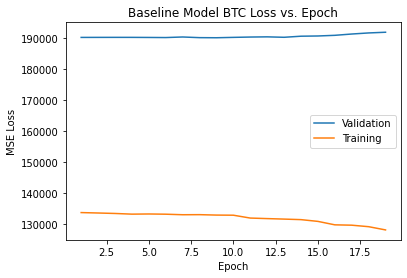

Epoch 17: early stopping
Novel1:
MAE   = 169.580
RMSE  = 256.058
MAPE  = 1.571
SMAPE = 1.570
R2    = 0.953




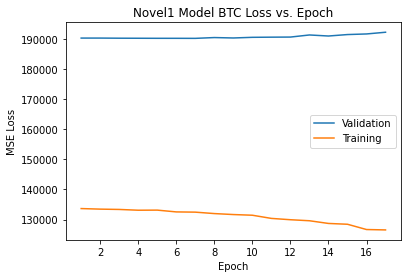

Epoch 40: early stopping
Novel2:
MAE   = 176.818
RMSE  = 259.838
MAPE  = 1.634
SMAPE = 1.638
R2    = 0.951




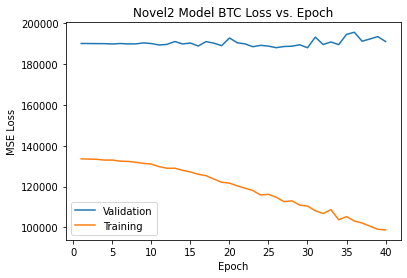

Epoch 15: early stopping
Novel3:
MAE   = 170.240
RMSE  = 256.155
MAPE  = 1.577
SMAPE = 1.576
R2    = 0.953




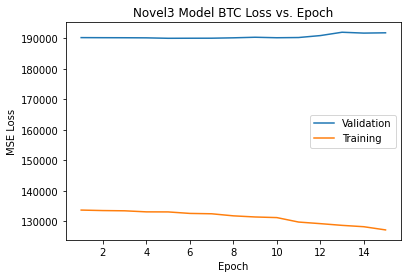

In [ ]:
def plotloss(title, modelname, val_loss, train_loss):
    xdata = np.arange(len(train_loss)) + 1
    plt.figure()
    plt.plot(xdata,val_loss, label = 'Validation')
    plt.plot(xdata,train_loss, label = 'Training')
    plt.title(title)
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'./{modelname}')
    plt.show()
modeldf = pd.DataFrame([], columns=['Model', 'MAE', 'RMSE', 'R2'])
choices = ['Baseline', 'Novel1', 'Novel2', 'Novel3']
for modelchoice in choices:
    checkpoint = ModelCheckpoint(modelchoice, 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min',
                              save_weights_only=True)

    if (modelchoice == 'Baseline'):
        model = basecomp(False)
 
    elif (modelchoice == 'Novel1'):
        model = novelcomp(printsummary = False, k1 = 1, k2 = 2, k3 = 3, conv1dmaps = 16, 
                 lay_padding = 'SAME', layer_act = 'relu')

    elif (modelchoice == 'Novel2'):
        model = novelcomp(printsummary = False, k1 = 2, k2 = 3, k3 = 4, conv1dmaps = 16, 
                 lay_padding = 'SAME', layer_act = 'relu')

    elif (modelchoice == 'Novel3'):
        model = novelcomp(printsummary = False, k1 = 1, k2 = 2, k3 = 3, conv1dmaps = 32, 
                 lay_padding = 'SAME', layer_act = 'relu')

    epochs         =  200
    batch_size     =  8
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop())

    score = model.fit(x = [trainX_btc, trainX_eth, trainX_xrp], 
                      y = trainY,
                      epochs          = epochs, 
                      batch_size      = batch_size, 
                      callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                      verbose         = 0, 
                      validation_data = ([validX_btc, validX_eth, validX_xrp], validY))

    model.load_weights(modelchoice)
    Prices = getpred(model)
    MAE, RMSE, R2 = getmetrics(modelchoice, Prices)
    val_loss = score.history['val_loss']
    train_loss = score.history['loss']
    
    plotloss(f'{modelchoice} Model {SeriesName} Loss vs. Epoch', modelchoice, val_loss, train_loss)
    modeldf.loc[len(modeldf.index)] = [modelchoice,MAE,RMSE,R2]
    del model
    del Prices
    gc.collect()
modeldf.head(6)
modeldf.to_csv(f'{SeriesName.lower()}_trans.csv')

In [ ]:
modeldf.to_csv(f'{SeriesName.lower()}_trans.csv')

In [ ]:
'''
from sklearn import metrics
import math

y_pred = model.predict([testX_btc, testX_eth, testX_xrp])
y_pred = np.squeeze(y_pred)

def smape(A, F):
    return ( 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)) ) )

def Regeval2( Y, Pred ):
    MAE   = metrics.mean_absolute_error(Y, Pred)
    RMSE  = math.sqrt(metrics.mean_squared_error(Y, Pred))
    MAPE  = np.mean(np.abs((Y - Pred) / Y)) * 100.0
    SMAPE = smape(Y, Pred)
    R2    = metrics.r2_score(Y, Pred)
    return (MAE, RMSE) #SMAPE, R2)
'''

'\nfrom sklearn import metrics\nimport math\n\ny_pred = model.predict([testX_btc, testX_eth, testX_xrp])\ny_pred = np.squeeze(y_pred)\n\ndef smape(A, F):\n    return ( 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)) ) )\n\ndef Regeval2( Y, Pred ):\n    MAE   = metrics.mean_absolute_error(Y, Pred)\n    RMSE  = math.sqrt(metrics.mean_squared_error(Y, Pred))\n    MAPE  = np.mean(np.abs((Y - Pred) / Y)) * 100.0\n    SMAPE = smape(Y, Pred)\n    R2    = metrics.r2_score(Y, Pred)\n    return (MAE, RMSE) #SMAPE, R2)\n'

In [ ]:
'''
y_pred = model.predict([testX_btc, testX_eth, testX_xrp])[:,0]

# Set DataFrame with 'Real' and 'Predicted' values
Prices = pd.DataFrame([], columns=[SeriesName, 'Predict'])
# Get real values

# Reverse transformation
if (Strategy == 'Differenced'):
    Prices[ SeriesName ]    = Testing[SeriesName][Lag:]
    Prices['Predict'] = Testing[SeriesName][Lag-1:-1 ].to_numpy() + y_pred
else:
    Prices[ SeriesName ] = np.exp( Testing[SeriesName][Lag:] )
    Prices['Predict']    = np.exp( Testing[SeriesName][Lag-1:-1].to_numpy() + y_pred )
    
ax = Prices.plot( figsize=(15,4), linewidth=2, marker='*')
ax.set_ylabel('Price')
plt.show()
'''

"\ny_pred = model.predict([testX_btc, testX_eth, testX_xrp])[:,0]\n\n# Set DataFrame with 'Real' and 'Predicted' values\nPrices = pd.DataFrame([], columns=[SeriesName, 'Predict'])\n# Get real values\n\n# Reverse transformation\nif (Strategy == 'Differenced'):\n    Prices[ SeriesName ]    = Testing[SeriesName][Lag:]\n    Prices['Predict'] = Testing[SeriesName][Lag-1:-1 ].to_numpy() + y_pred\nelse:\n    Prices[ SeriesName ] = np.exp( Testing[SeriesName][Lag:] )\n    Prices['Predict']    = np.exp( Testing[SeriesName][Lag-1:-1].to_numpy() + y_pred )\n    \nax = Prices.plot( figsize=(15,4), linewidth=2, marker='*')\nax.set_ylabel('Price')\nplt.show()\n"

In [ ]:
# Regression performance
#
'''
MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )
#
print('MAE   = %.3f' % MAE)
print('RMSE  = %.3f' % RMSE)
print('MAPE  = %.3f' % MAPE)
print('SMAPE = %.3f' % SMAPE)
print('R2    = %.3f' % R2)
print('\n')
'''


'''
# Classification performance
#
CM, Accuracy, AUC, F1, GM, Sen, Spe, PPV, NPV = ClassificationEvaluation( Prices )
#
print('Accuracy  = %.2f%%' % (100*Accuracy))
print('AUC       = %.3f' % AUC)
print('F1        = %.3f' % F1)
print('GM        = %.3f' % GM)
print('Sen       = %.3f' % Sen)
print('Spe       = %.3f' % Spe)
print('Spe x Sen = %.3f' % (Sen*Spe))
print('\n')


# Confusion matrix
#
ConfusionMatrixVisualize(CM)
'''

"\n# Classification performance\n#\nCM, Accuracy, AUC, F1, GM, Sen, Spe, PPV, NPV = ClassificationEvaluation( Prices )\n#\nprint('Accuracy  = %.2f%%' % (100*Accuracy))\nprint('AUC       = %.3f' % AUC)\nprint('F1        = %.3f' % F1)\nprint('GM        = %.3f' % GM)\nprint('Sen       = %.3f' % Sen)\nprint('Spe       = %.3f' % Spe)\nprint('Spe x Sen = %.3f' % (Sen*Spe))\nprint('\n')\n\n\n# Confusion matrix\n#\nConfusionMatrixVisualize(CM)\n"